In [237]:
import numpy as np
from matplotlib import pyplot as plt

from qutrit_rpe import *
import pygsti

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Circuit Generation

In [238]:
qids = ['Q4', 'Q5']

In [239]:
depths_1qt = [2**i for i in range(10)]
depths_2qt = [2**i for i in range(6)]
edesign_qid0 = RPEDesign1QT(depths_1qt, qids[0], qids)
edesign_qid1 = RPEDesign1QT(depths_1qt, qids[1], qids)
edesign_cz = RPEDesign2QT(depths_2qt, qids)

In [240]:
edesign_qid0.save_circuits('rpe_circuits_qid0.txt')
edesign_qid1.save_circuits('rpe_circuits_qid1.txt')
edesign_cz.save_circuits('rpe_circuits_cz.txt')

# Model Definition

In [241]:
xvec = random_error_vector(0.0001, 0.001)
depol_rates = [0.0001, 0.001] # 1 and 2 qubit depolarizing rates
noise_model =  make_two_qutrit_model(xvec, single_qutrit_depol=depol_rates[0], two_qutrit_depol=depol_rates[1], qids=qids)
target_model = make_two_qutrit_model(np.zeros(16), single_qutrit_depol=0.0, two_qutrit_depol=0.0, qids=qids)
parse_error_vector(xvec, qids)

{'single_qutrit': {'Q4': {'X01': 0.005600568639047699,
   'phase01': 0.0002917409153911476,
   'X12': -0.008404627802780599,
   'phase12': 0.007007759551384574},
  'Q5': {'X01': -0.004364558046820886,
   'phase01': -0.0024326724491811644,
   'X12': -0.008884017821531379,
   'phase12': -0.014463760004739317}},
 'two_qutrit': {'phi1': -0.05642133437916107,
  'phi2': -0.0014576648939627493,
  'phi3': -0.02765900028482788,
  'phi4': -0.03987077124812893,
  'phi5': 0.012476392118597664,
  'phi6': 0.06469179389399808,
  'phi7': 0.009179363952836304,
  'phi8': 0.00275647507397712}}

# Circuit Simulation

In [242]:
num_samples = 1000

In [243]:
ds_qid0 = pygsti.data.simulate_data(noise_model, edesign_qid0.circ_list, num_samples=num_samples)
ds_qid1 = pygsti.data.simulate_data(noise_model, edesign_qid1.circ_list, num_samples=num_samples)
ds_cz = pygsti.data.simulate_data(noise_model, edesign_cz.circ_list, num_samples=num_samples)

In [244]:
# save the datasets 
pygsti.io.writers.write_dataset('qid0_ds.txt', ds_qid0)
pygsti.io.writers.write_dataset('qid1_ds.txt', ds_qid1)
pygsti.io.writers.write_dataset('cz_ds.txt', ds_cz)

# Analysis

In [245]:
# load the datasets
ds_qid0 = pygsti.io.load_dataset('qid0_ds.txt')
ds_qid1 = pygsti.io.load_dataset('qid1_ds.txt')
ds_cz = pygsti.io.load_dataset('cz_ds.txt')

Reading cz_ds.txt: 100%


In [246]:
estimator_qid0 = RPEEstimator1QT(ds_qid0, edesign_qid0, germ_quadrature_labels_Q0)
estimator_qid1 = RPEEstimator1QT(ds_qid1, edesign_qid1, germ_quadrature_labels_Q1)
estimator_cz = RPEEstimator2QT(ds_cz, edesign_cz, germ_quadrature_labels_CZ)

In [247]:
qid0_results = estimator_qid0.param_estimates
qid1_results = estimator_qid1.param_estimates
cz_results = estimator_cz.param_estimates

In [248]:
xhat = reconstruct_error_vector(qid0_results, qid1_results, cz_results)

In [249]:
xhat

array([ 0.00566754,  0.00028324, -0.00840704,  0.00703195, -0.00439876,
       -0.00243658, -0.00902762, -0.01447584, -0.05819264, -0.00458912,
       -0.02918704, -0.04226355,  0.00835815,  0.06483767,  0.00909334,
       -0.00032073])

In [250]:
xvec

array([ 0.00560057,  0.00029174, -0.00840463,  0.00700776, -0.00436456,
       -0.00243267, -0.00888402, -0.01446376, -0.05642133, -0.00145766,
       -0.027659  , -0.03987077,  0.01247639,  0.06469179,  0.00917936,
        0.00275648])

<BarContainer object of 16 artists>

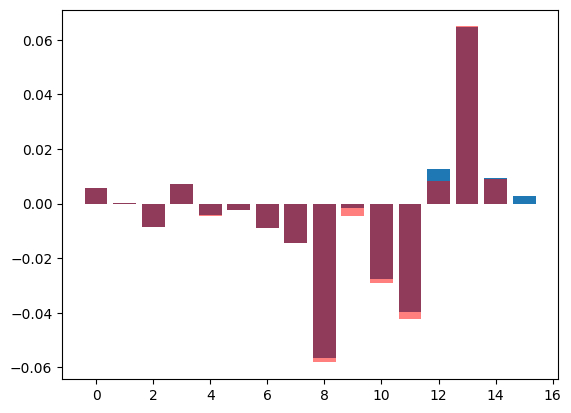

In [251]:
# plot the true and estimated errors on top of each other
plt.bar(range(16), xvec)
plt.bar(range(16), xhat, color='r', alpha=0.5)

In [252]:
parse_error_vector(xhat, qids)


{'single_qutrit': {'Q4': {'X01': 0.005667536048067134,
   'phase01': 0.0002832361750105446,
   'X12': -0.008407035701963217,
   'phase12': 0.0070319511759090085},
  'Q5': {'X01': -0.004398762673046619,
   'phase01': -0.0024365763980765585,
   'X12': -0.009027620848995888,
   'phase12': -0.01447584090906299}},
 'two_qutrit': {'phi1': -0.05819263520661977,
  'phi2': -0.004589119928871455,
  'phi3': -0.029187036015908774,
  'phi4': -0.04226354544947242,
  'phi5': 0.008358146089656238,
  'phi6': 0.06483766819606007,
  'phi7': 0.009093338982909316,
  'phi8': -0.00032073021878709085}}

In [253]:
parse_error_vector(xvec, qids)

{'single_qutrit': {'Q4': {'X01': 0.005600568639047699,
   'phase01': 0.0002917409153911476,
   'X12': -0.008404627802780599,
   'phase12': 0.007007759551384574},
  'Q5': {'X01': -0.004364558046820886,
   'phase01': -0.0024326724491811644,
   'X12': -0.008884017821531379,
   'phase12': -0.014463760004739317}},
 'two_qutrit': {'phi1': -0.05642133437916107,
  'phi2': -0.0014576648939627493,
  'phi3': -0.02765900028482788,
  'phi4': -0.03987077124812893,
  'phi5': 0.012476392118597664,
  'phi6': 0.06469179389399808,
  'phi7': 0.009179363952836304,
  'phi8': 0.00275647507397712}}

# Visualization

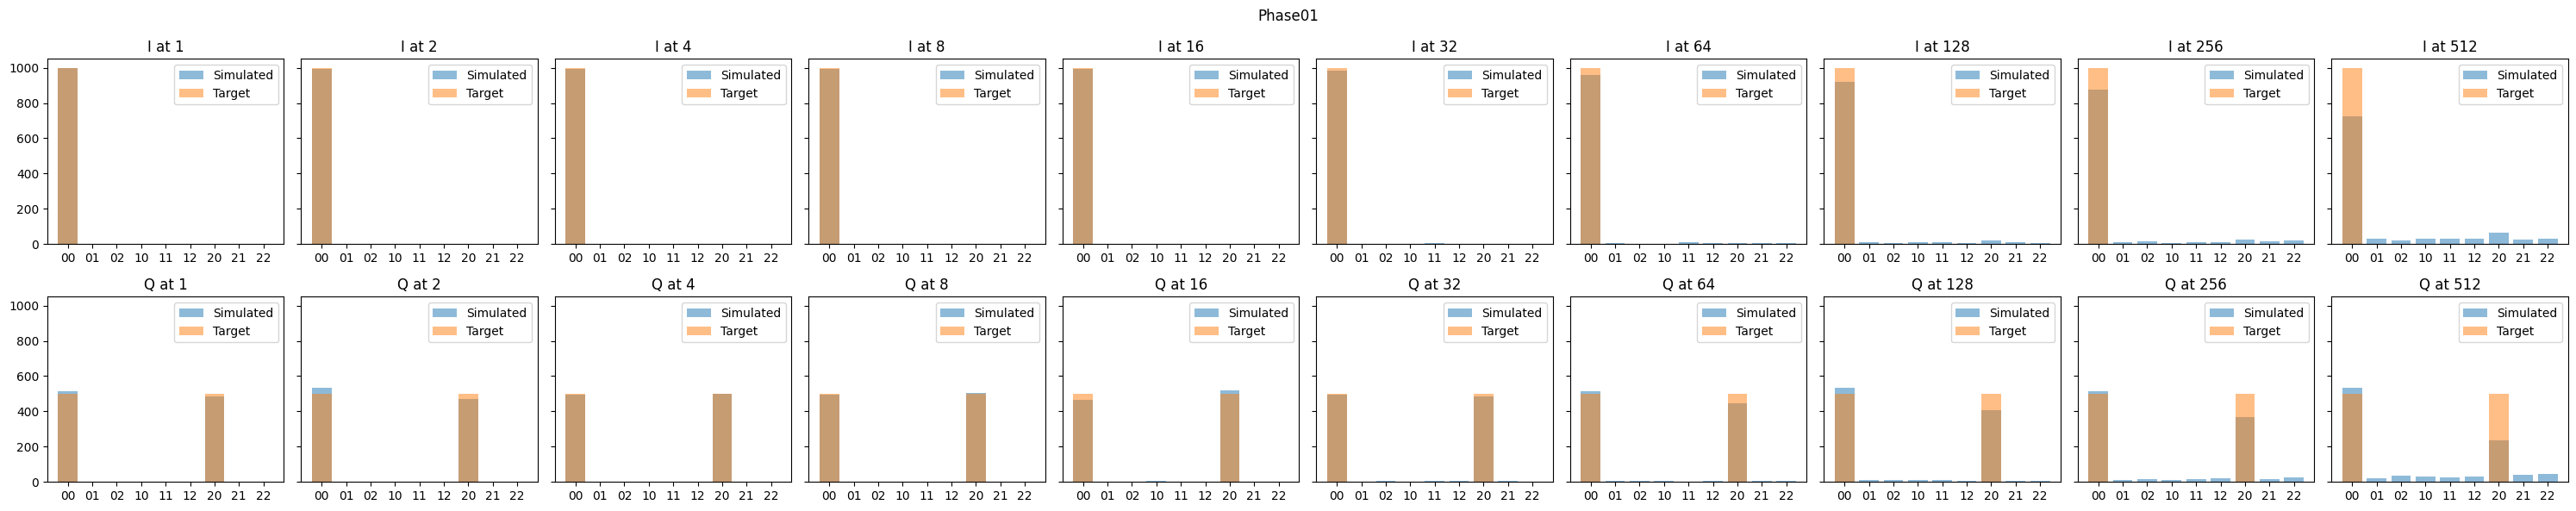

<Figure size 640x480 with 0 Axes>

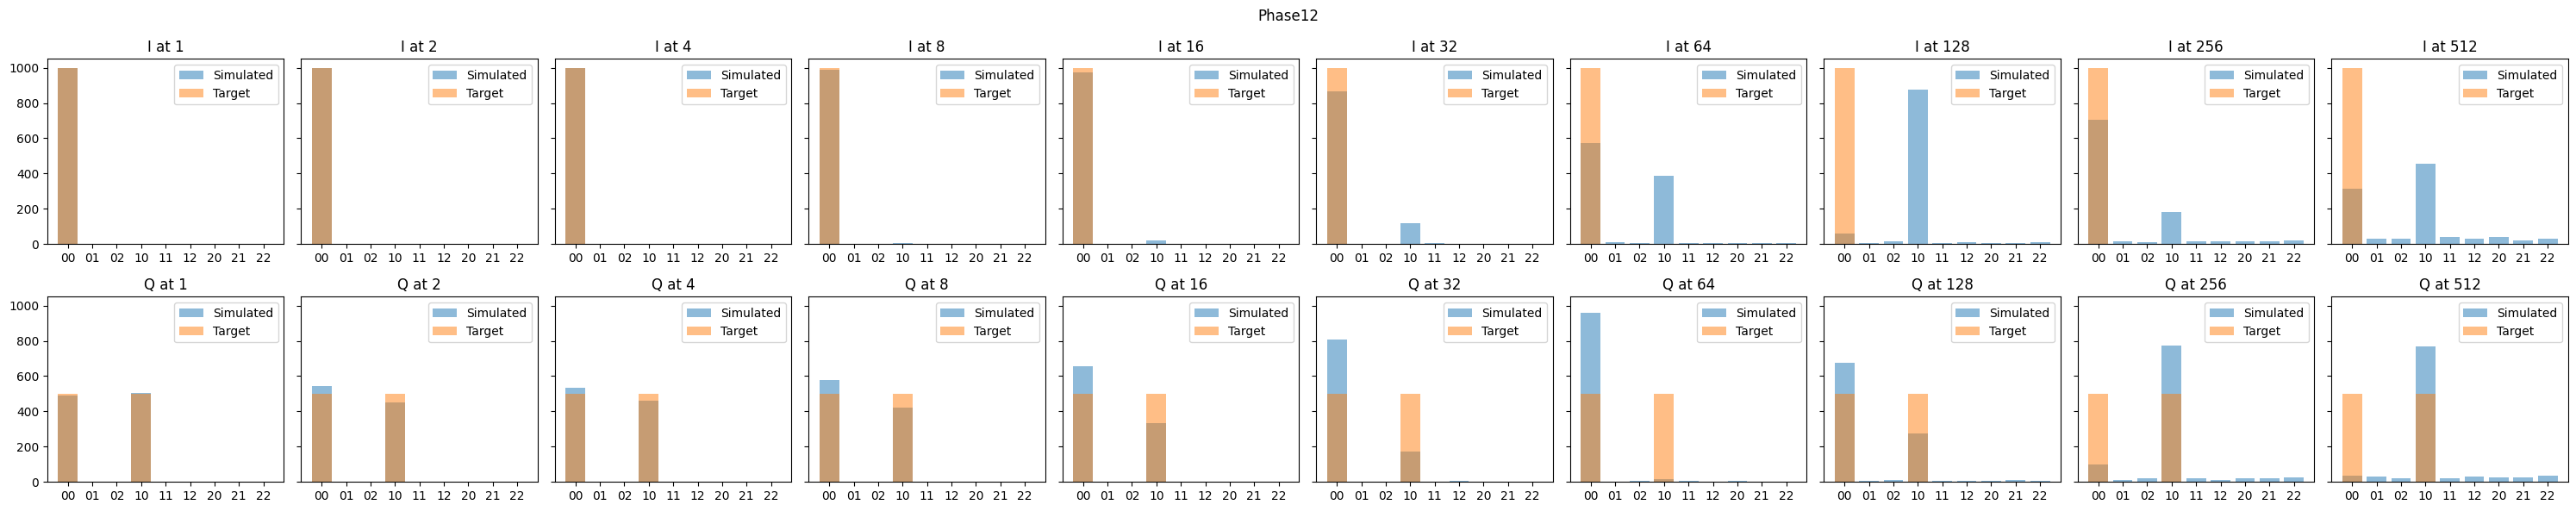

<Figure size 640x480 with 0 Axes>

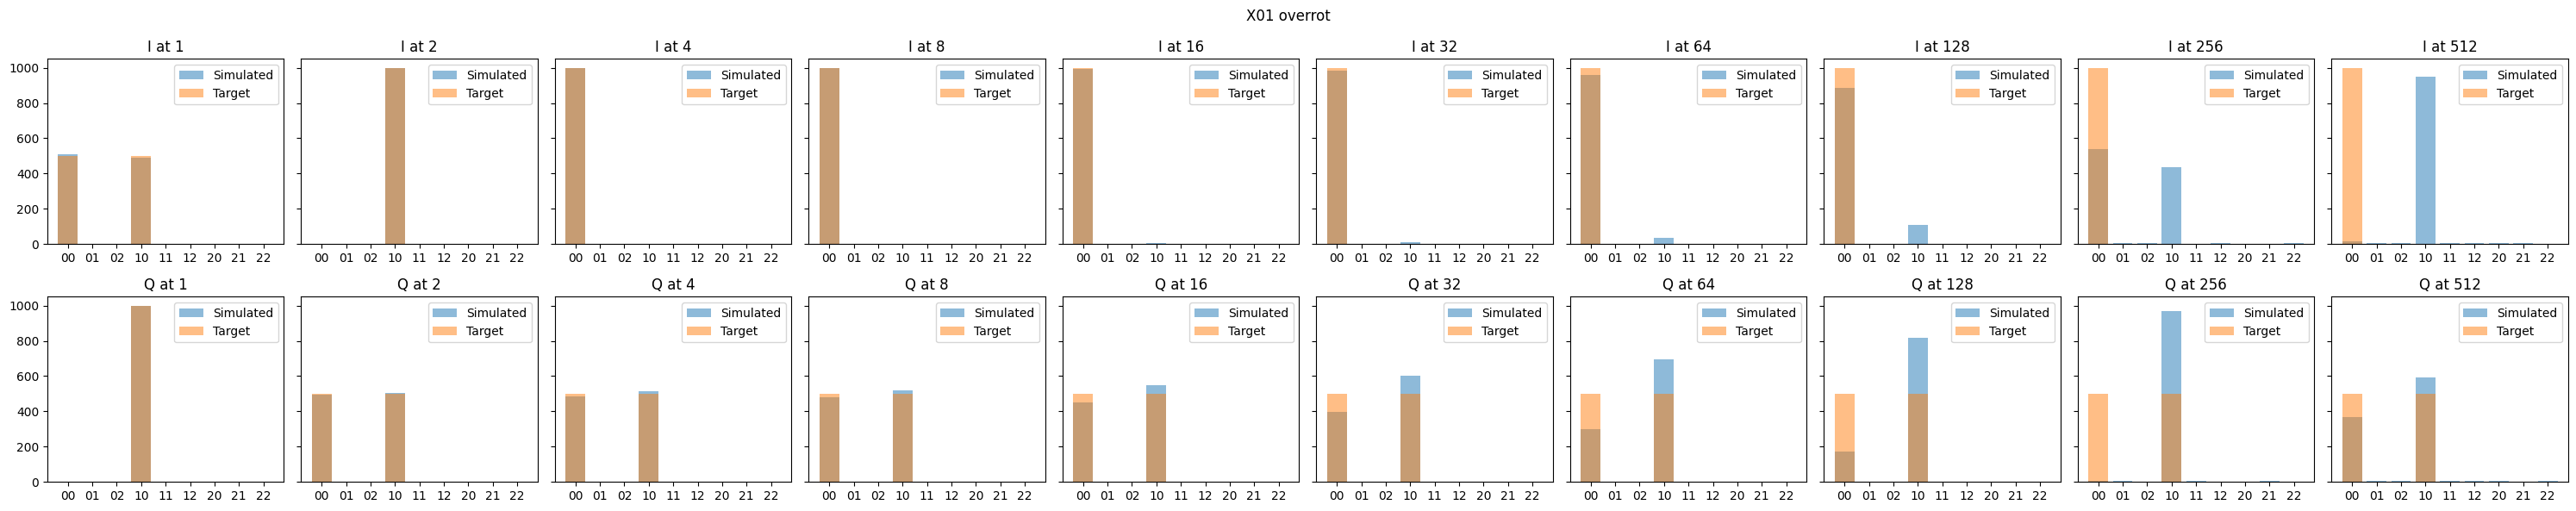

<Figure size 640x480 with 0 Axes>

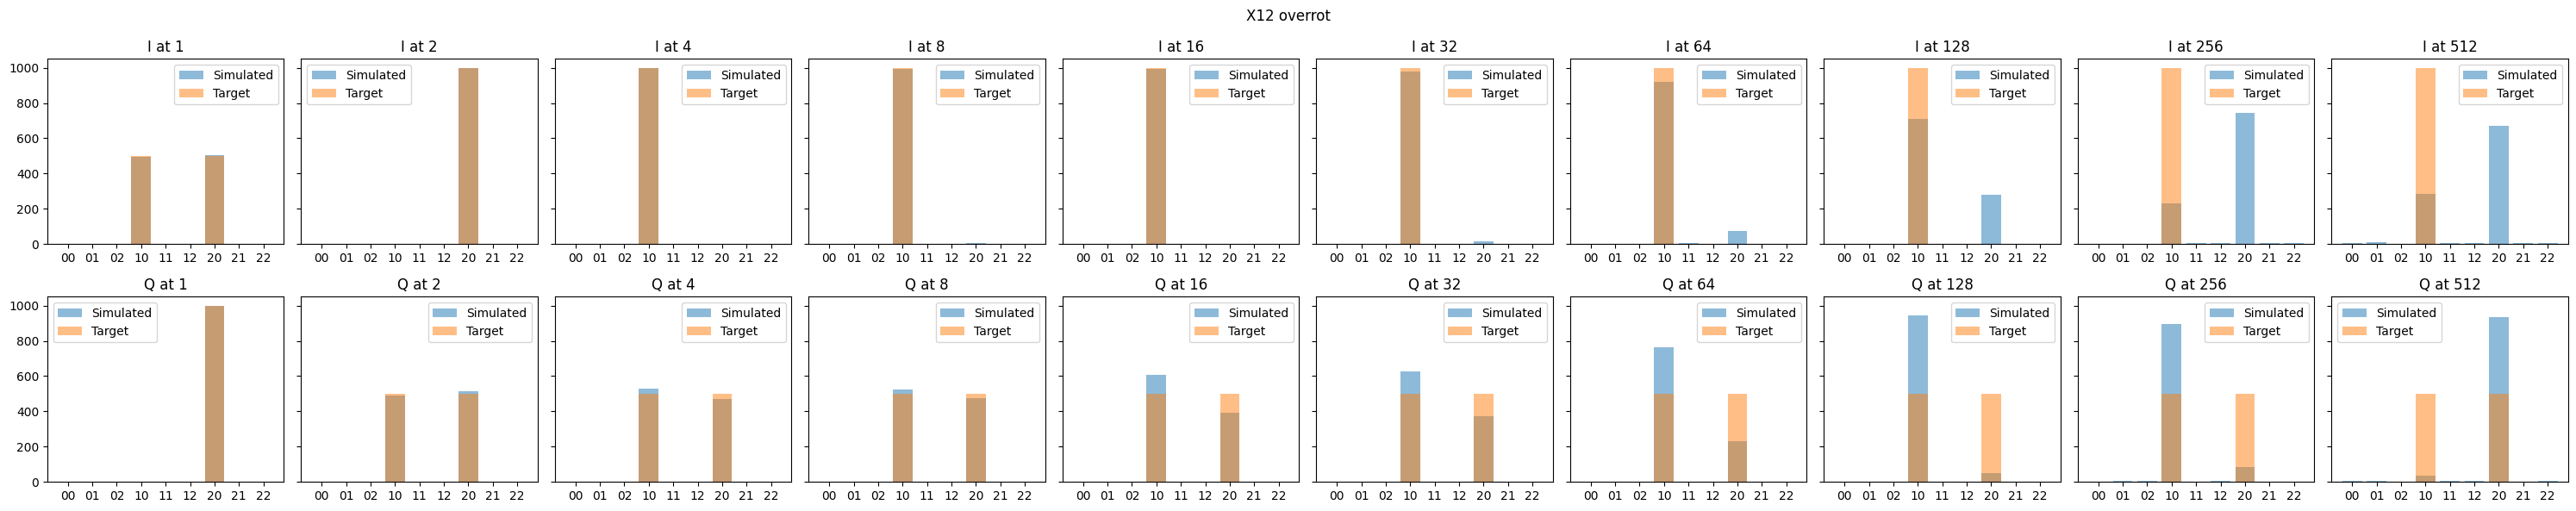

<Figure size 640x480 with 0 Axes>

In [263]:
estimator_qid0.plot_all_outcomes(target_model=target_model)

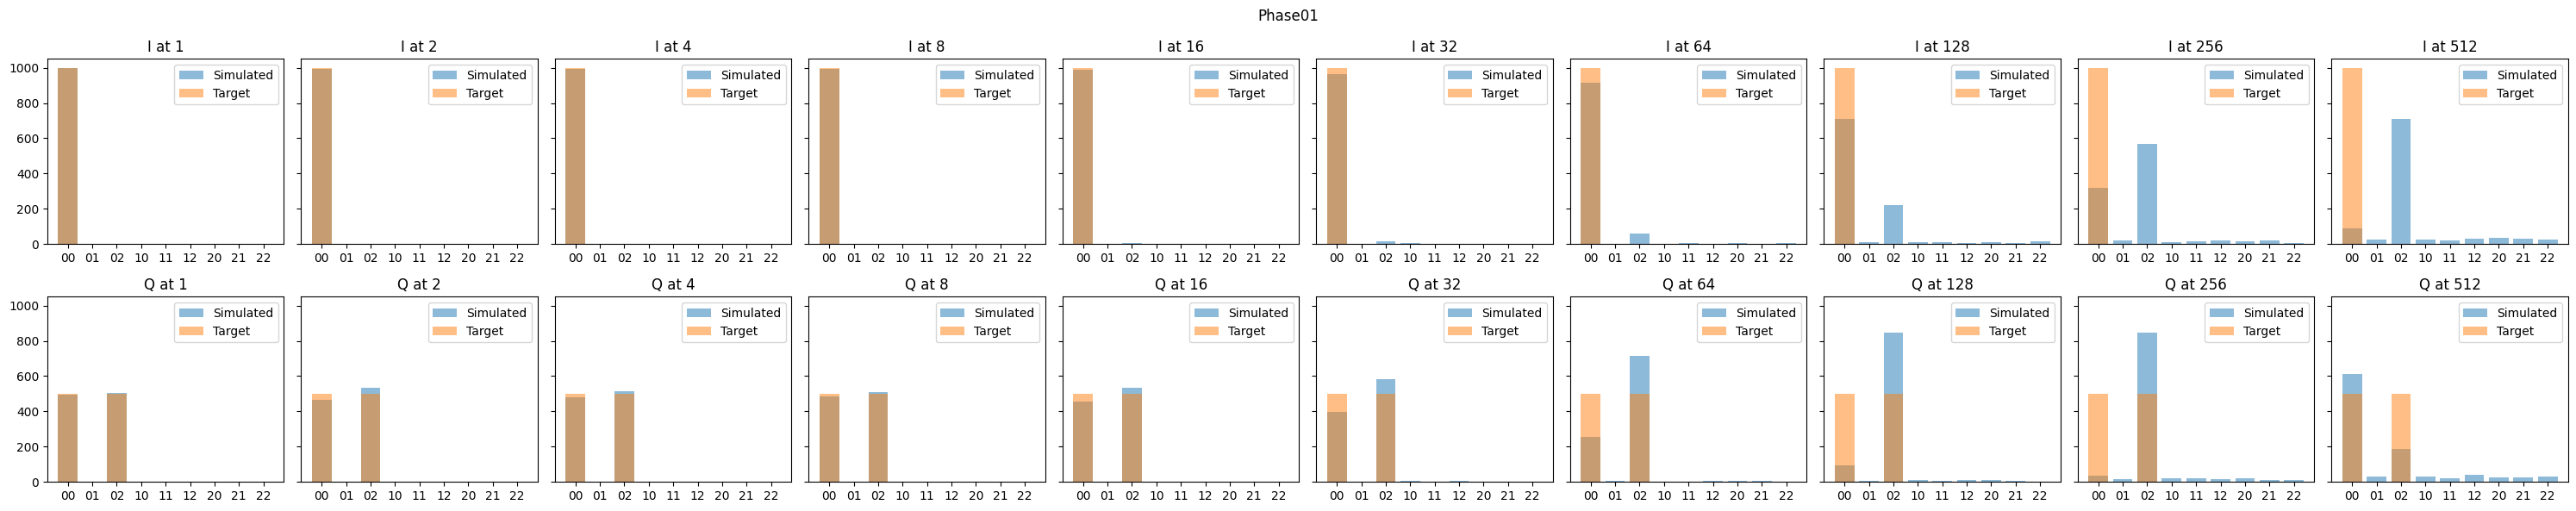

<Figure size 640x480 with 0 Axes>

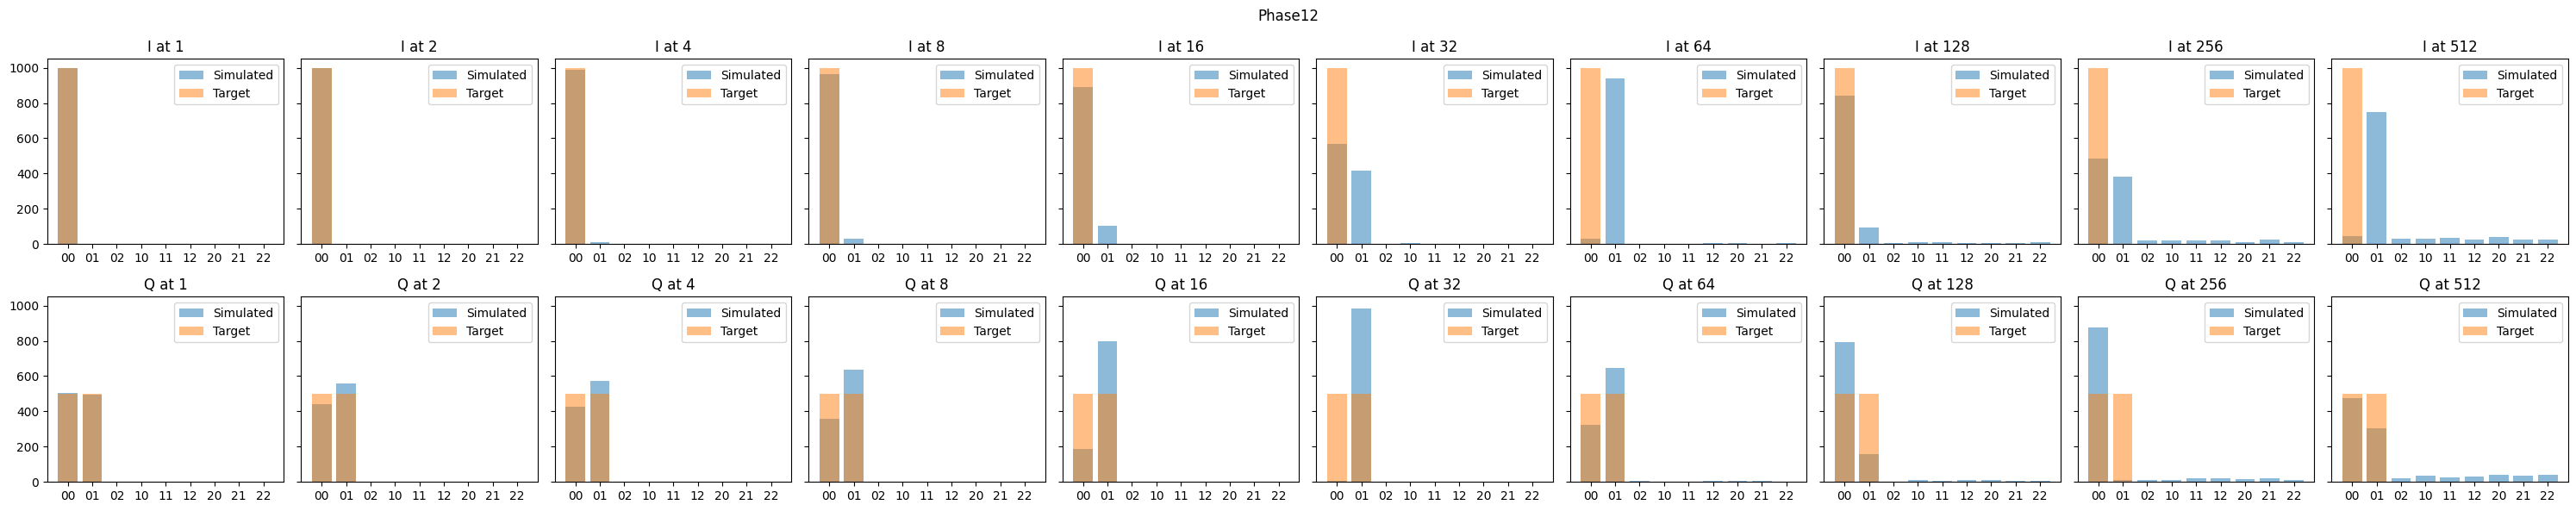

<Figure size 640x480 with 0 Axes>

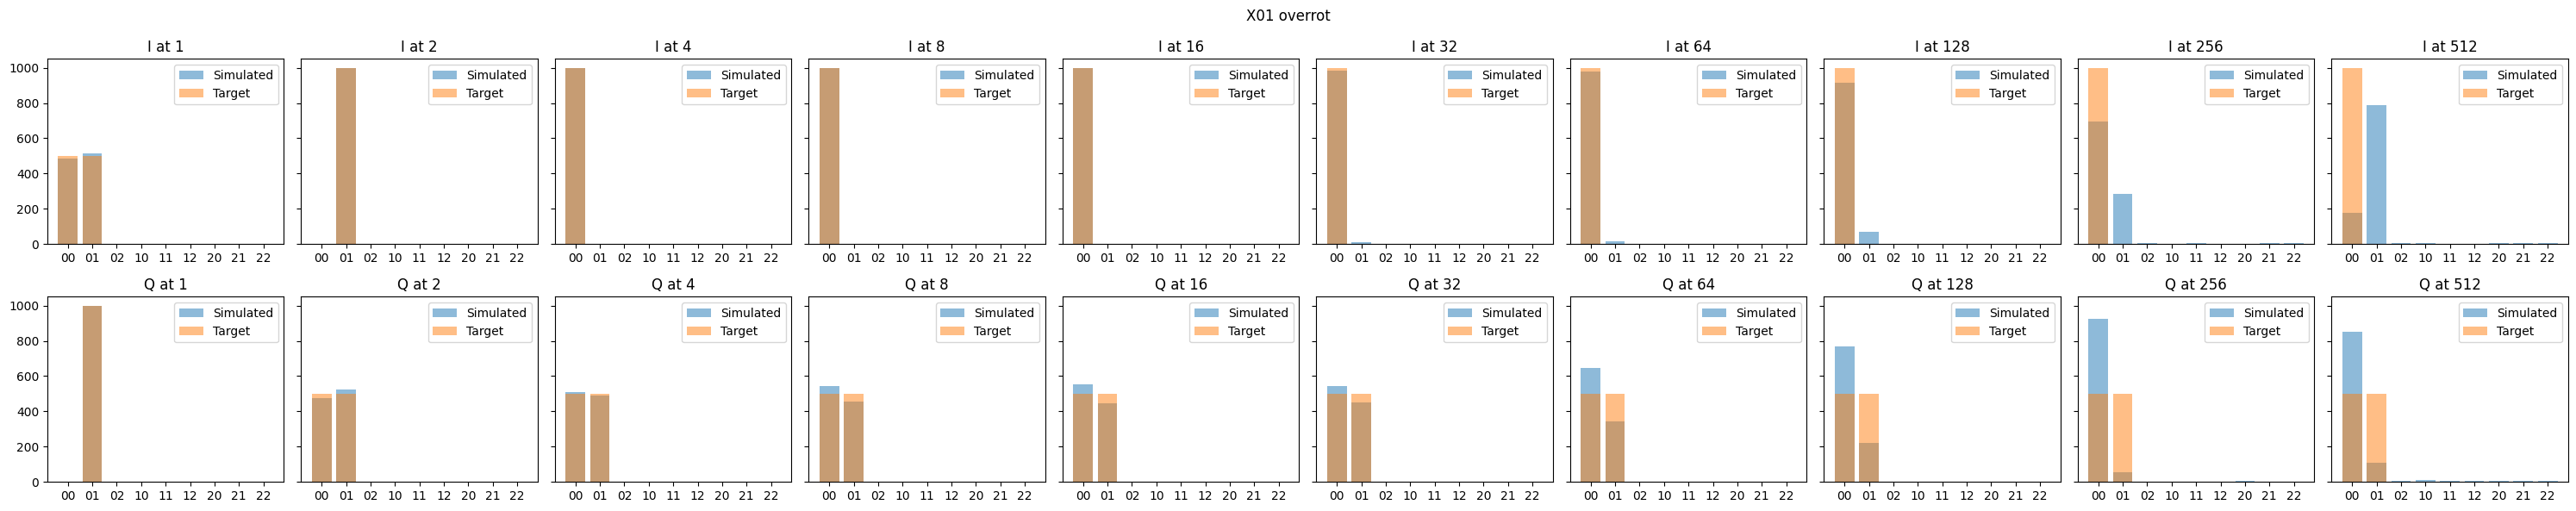

<Figure size 640x480 with 0 Axes>

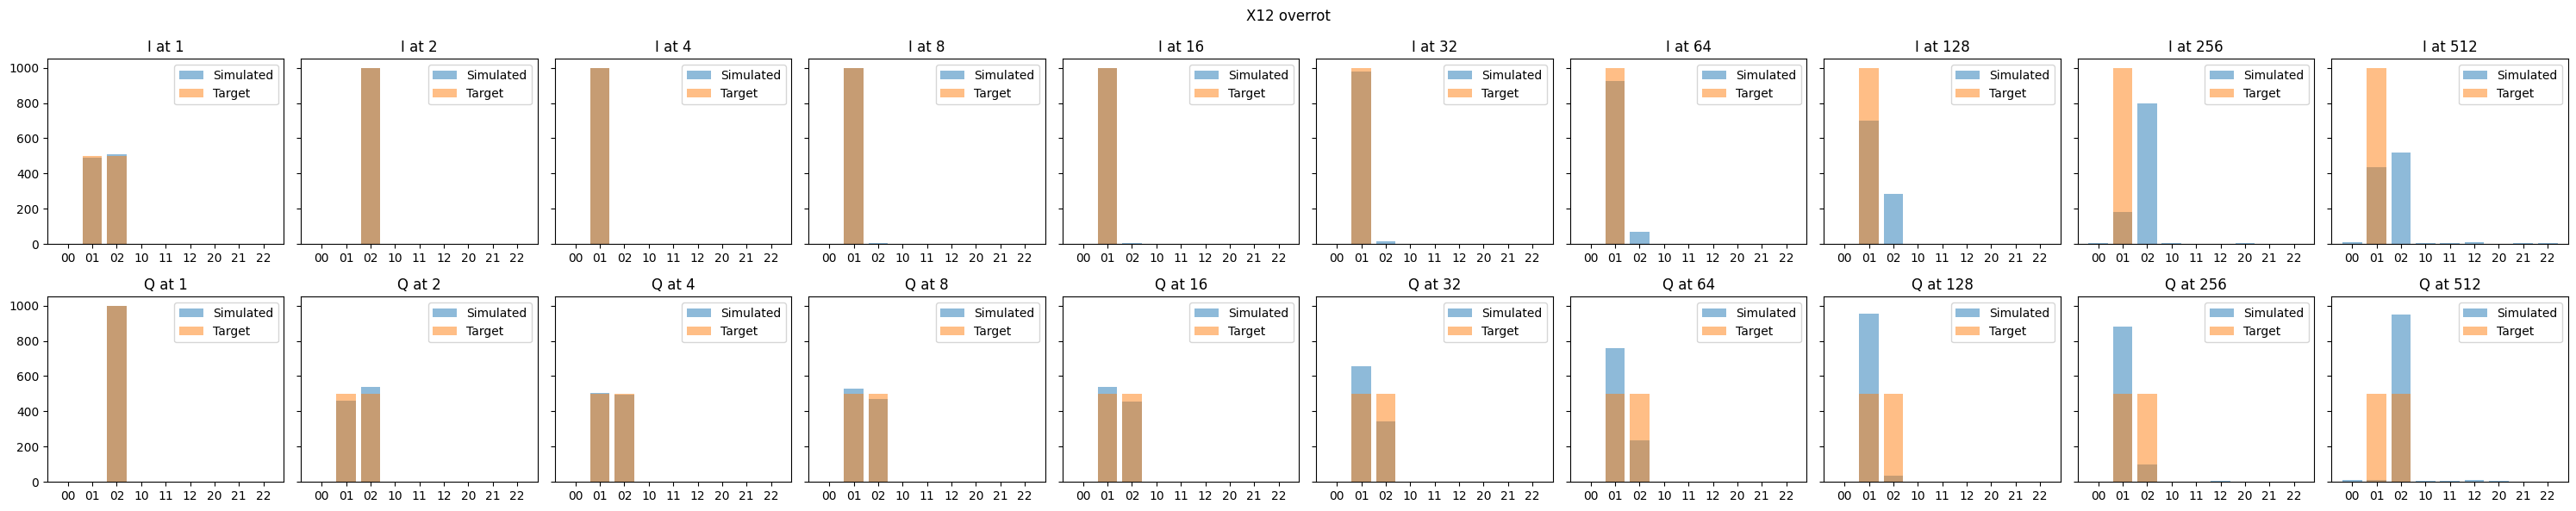

<Figure size 640x480 with 0 Axes>

In [264]:
estimator_qid1.plot_all_outcomes(target_model=target_model)

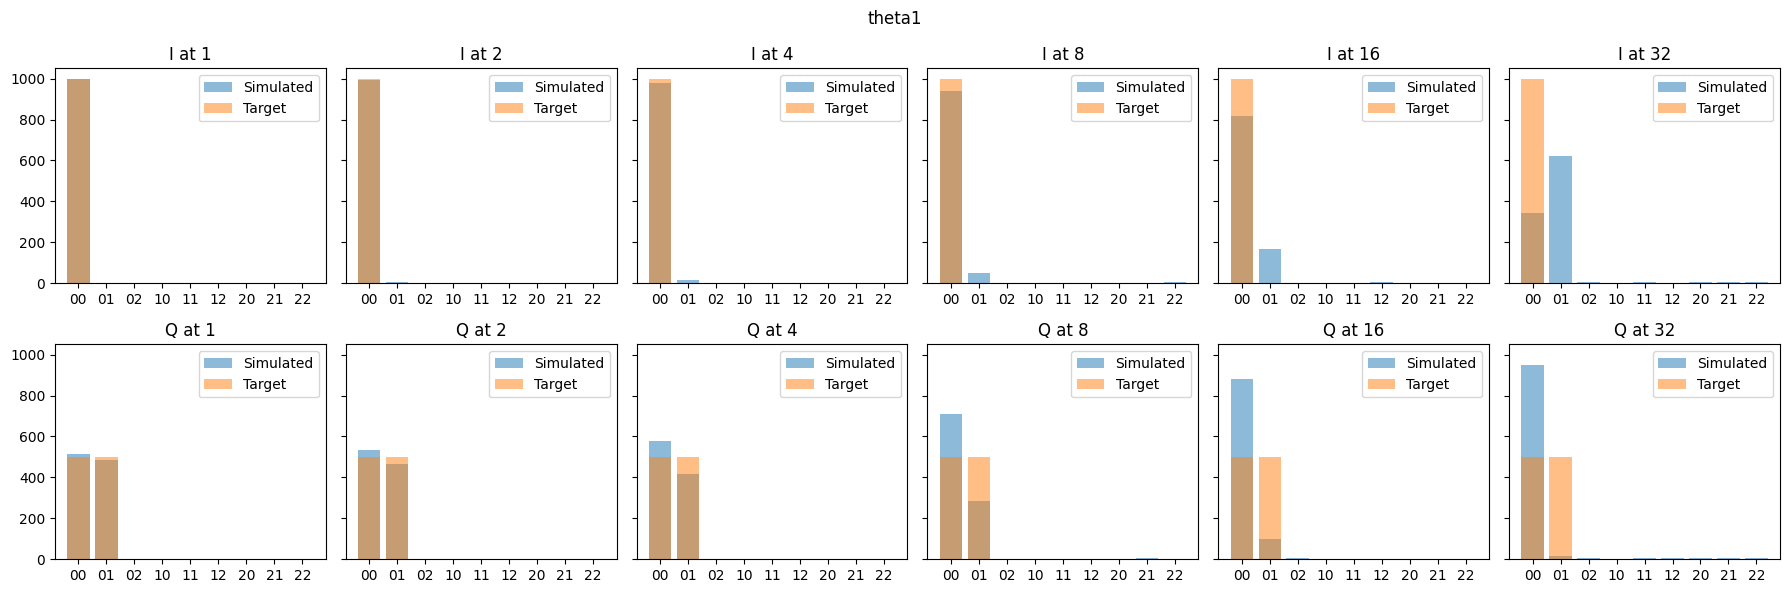

<Figure size 640x480 with 0 Axes>

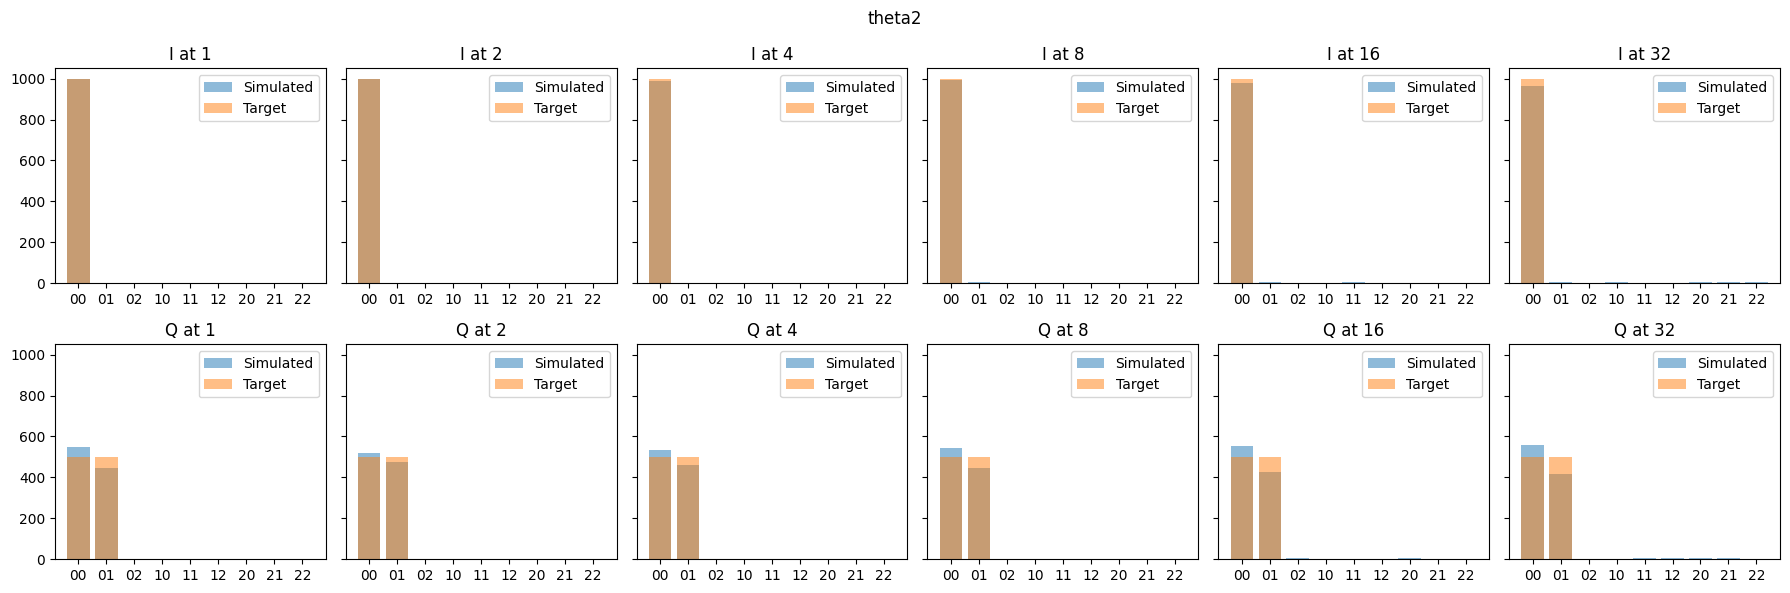

<Figure size 640x480 with 0 Axes>

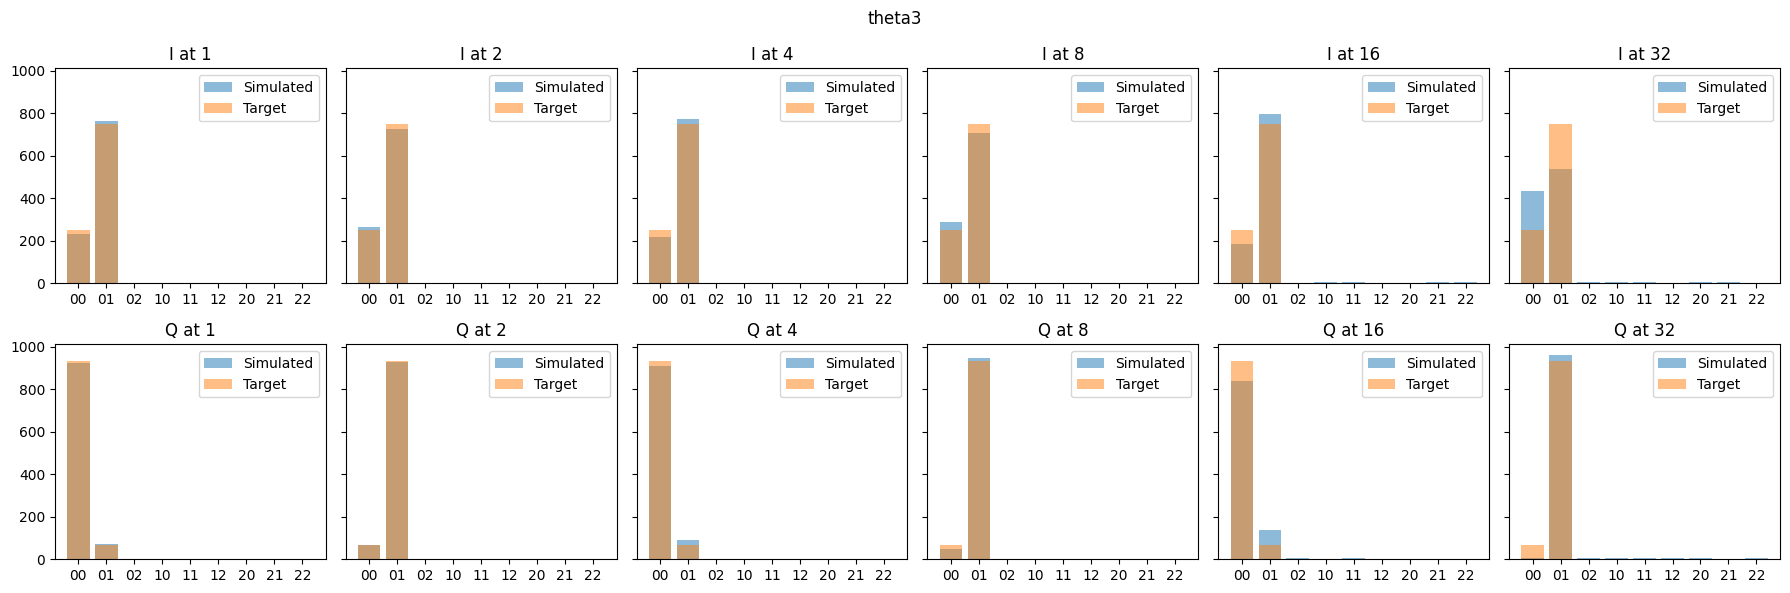

<Figure size 640x480 with 0 Axes>

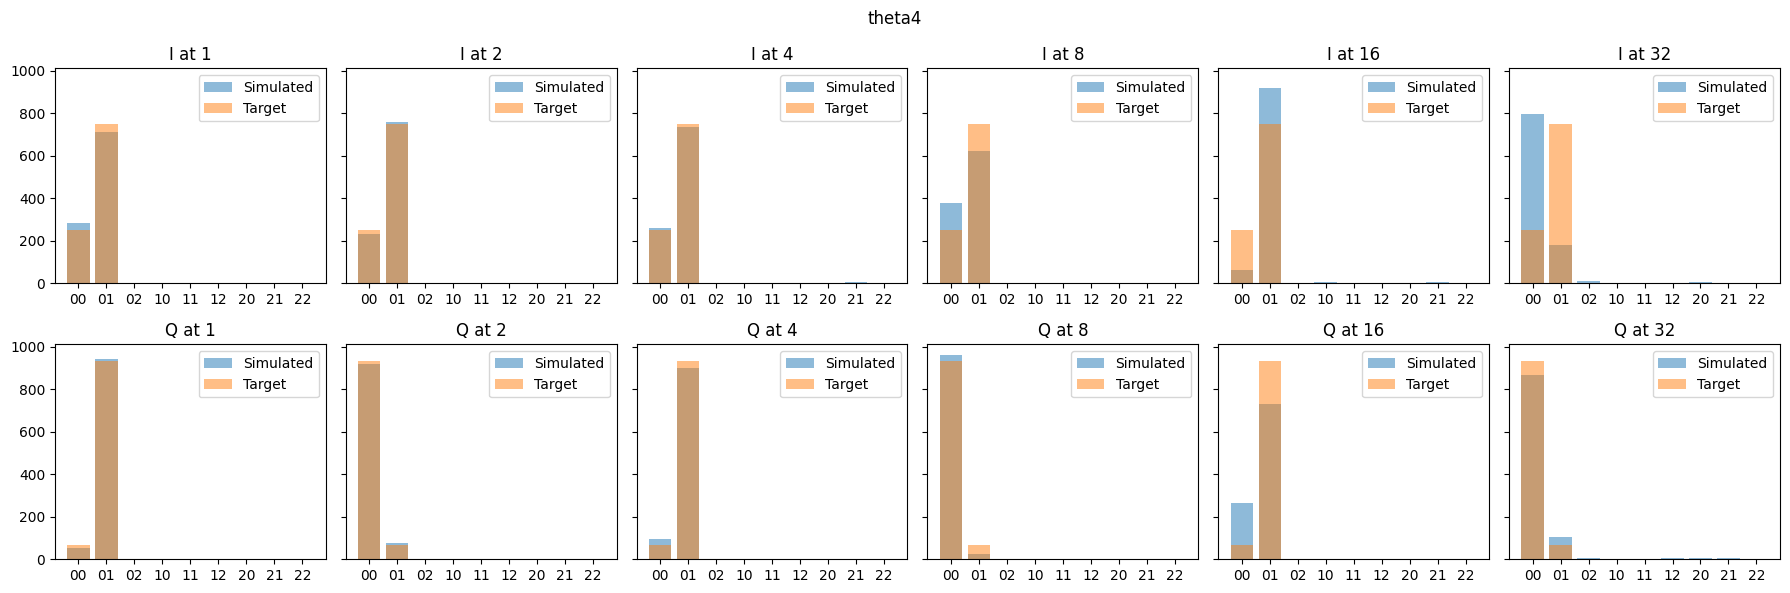

<Figure size 640x480 with 0 Axes>

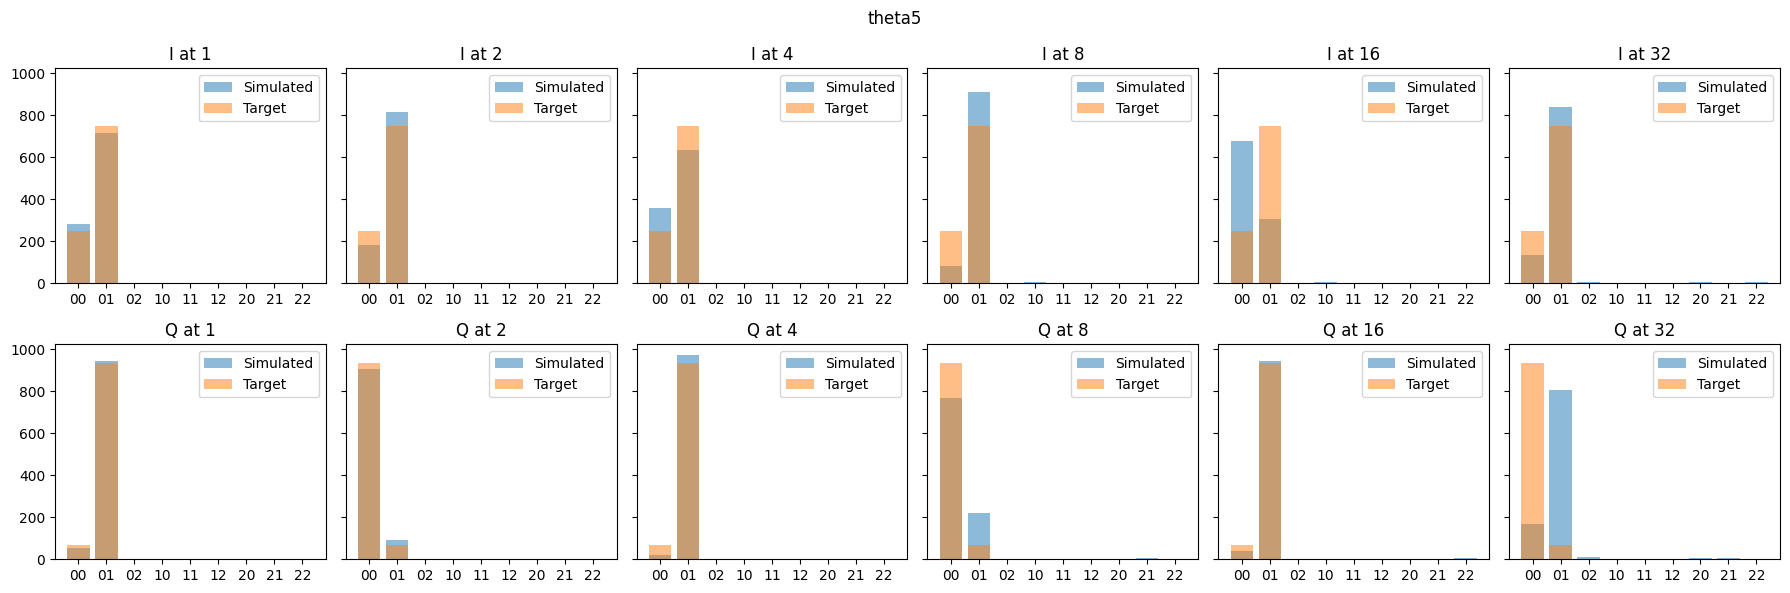

<Figure size 640x480 with 0 Axes>

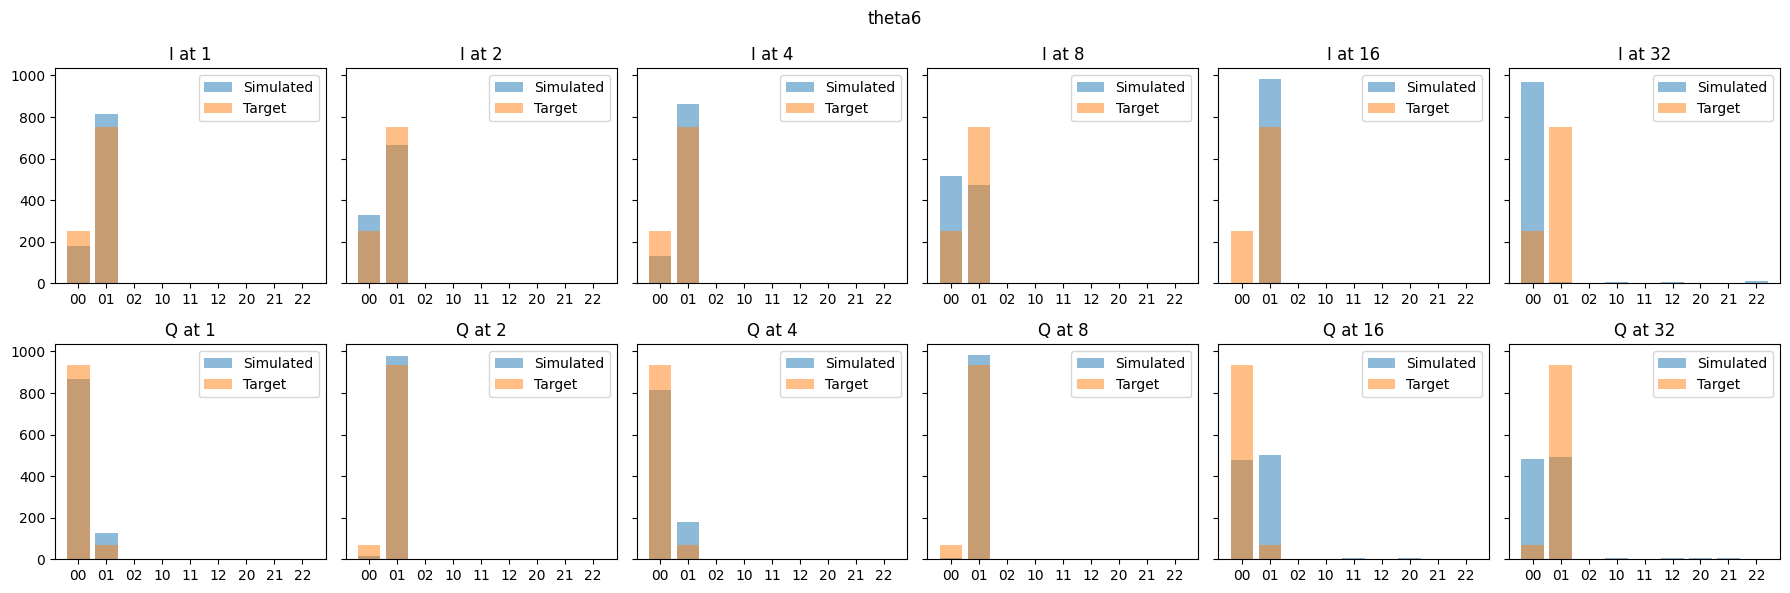

<Figure size 640x480 with 0 Axes>

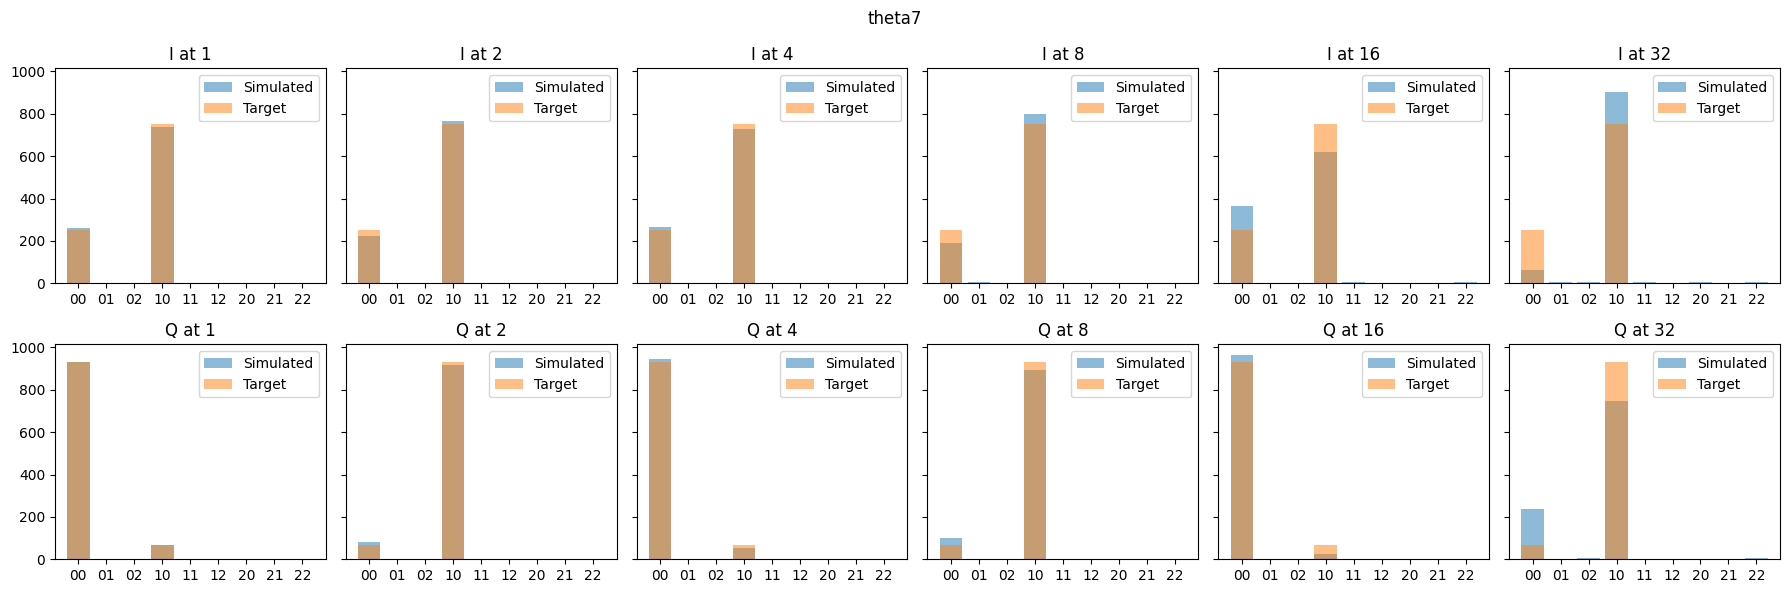

<Figure size 640x480 with 0 Axes>

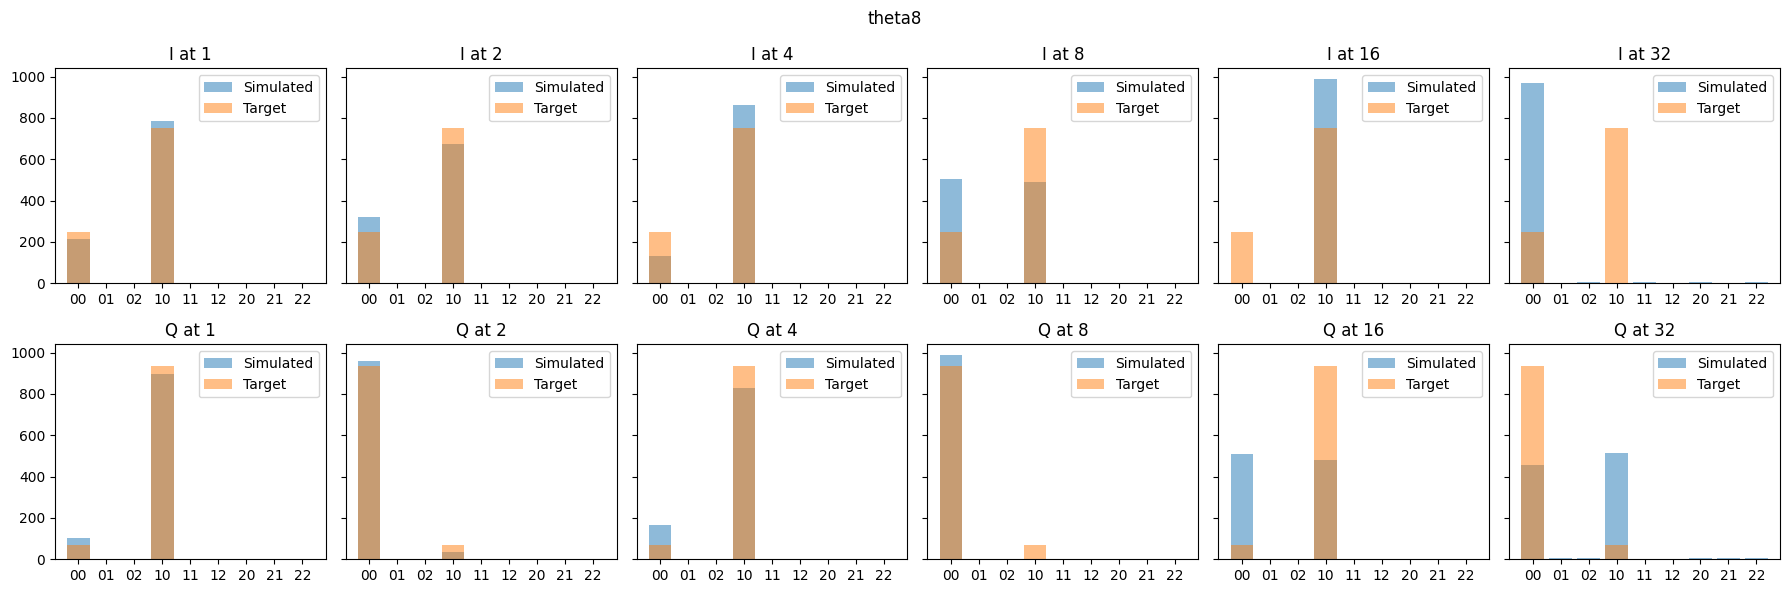

<Figure size 640x480 with 0 Axes>

In [265]:
estimator_cz.plot_all_outcomes(target_model=target_model)

# Signals on circle

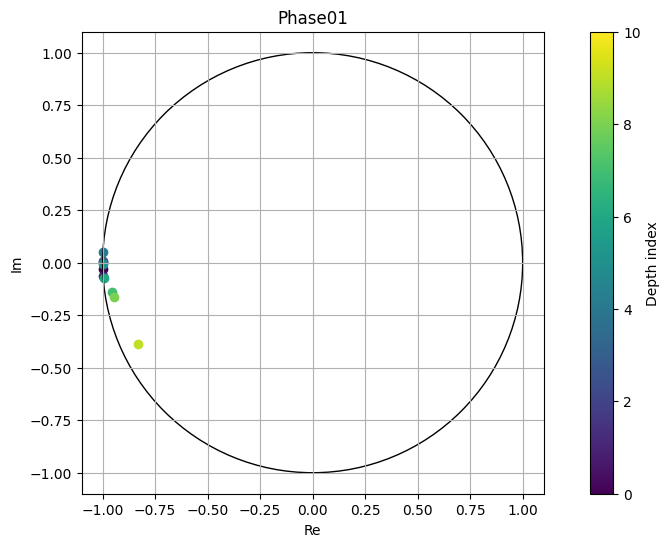

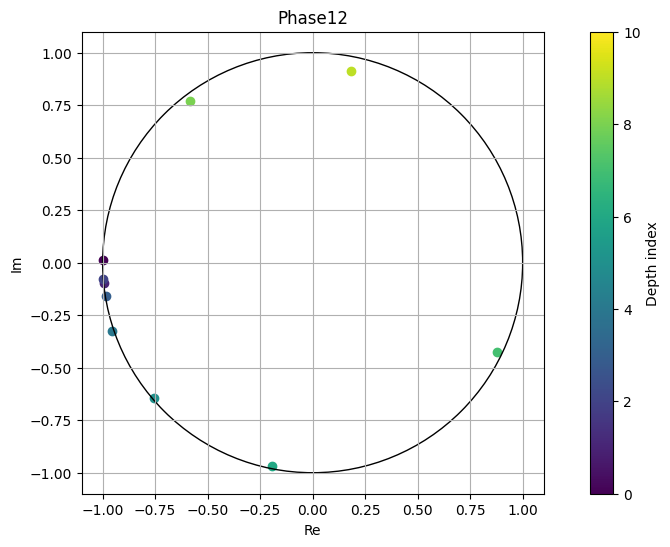

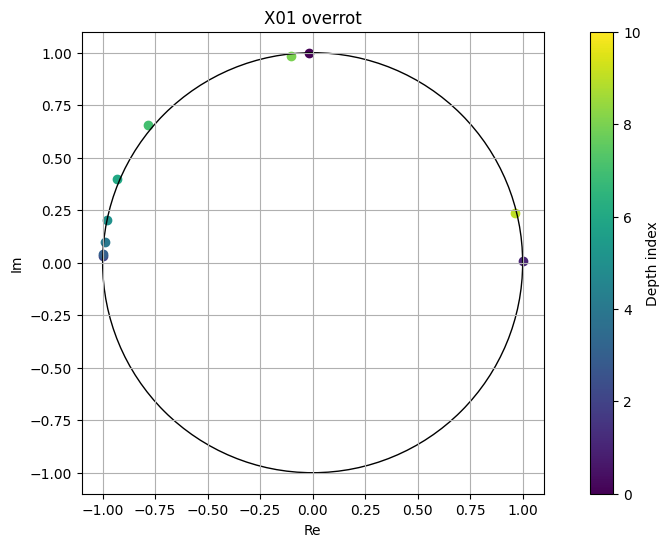

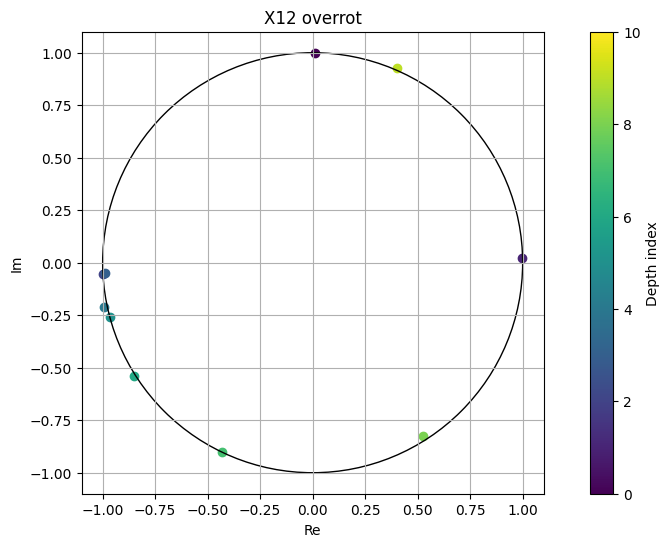

In [266]:
estimator_qid0.plot_all_signals()

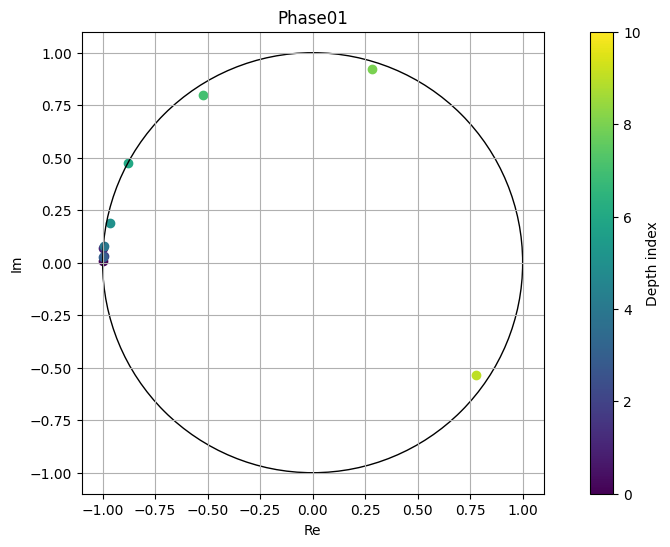

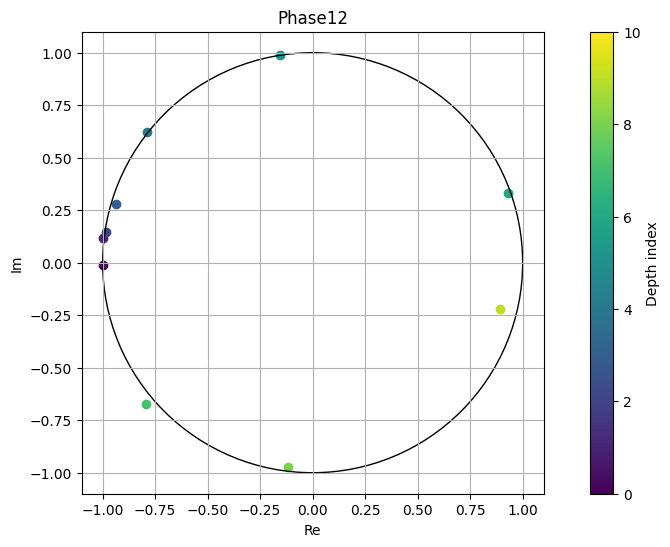

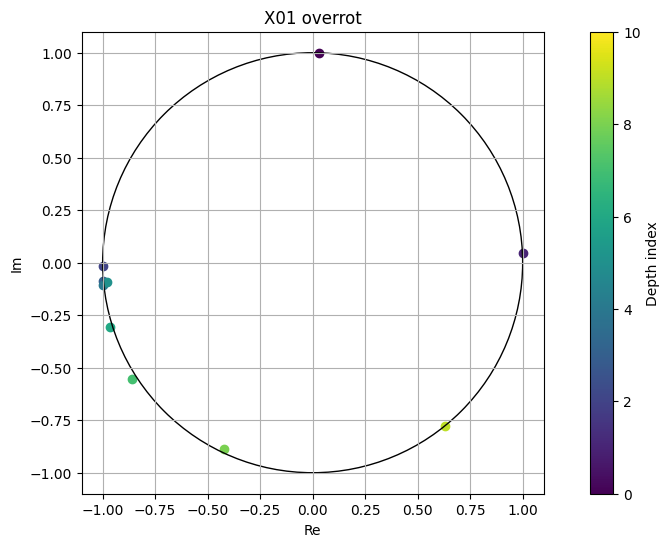

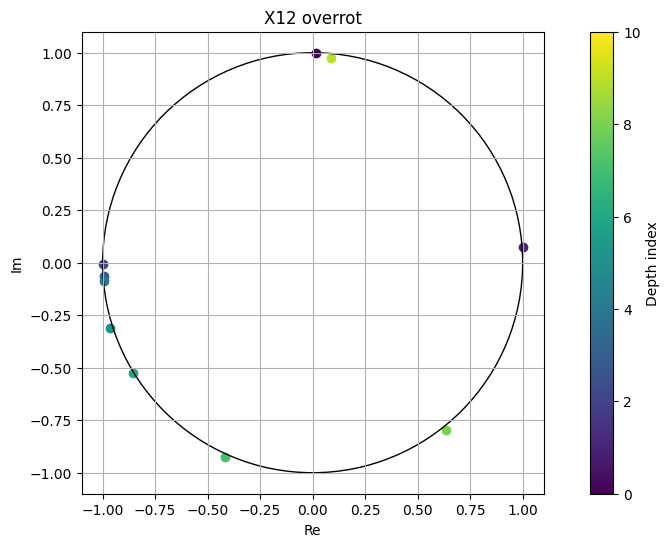

In [267]:
estimator_qid1.plot_all_signals()

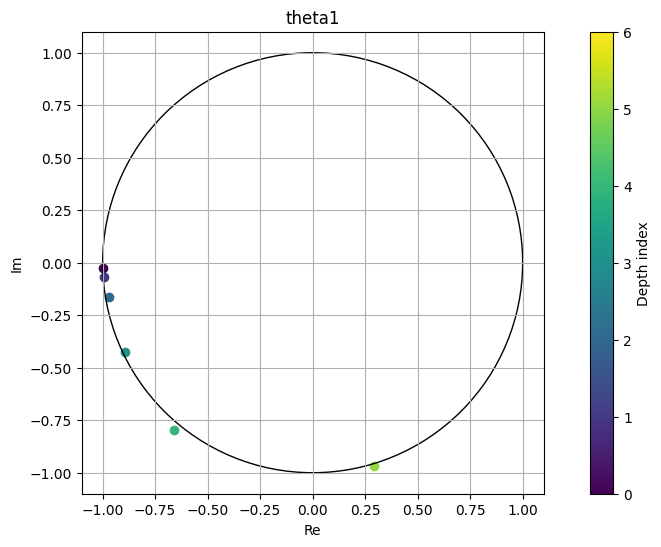

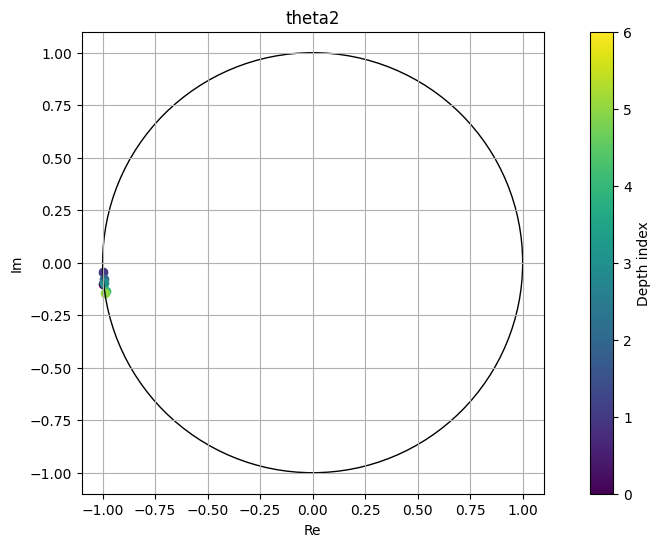

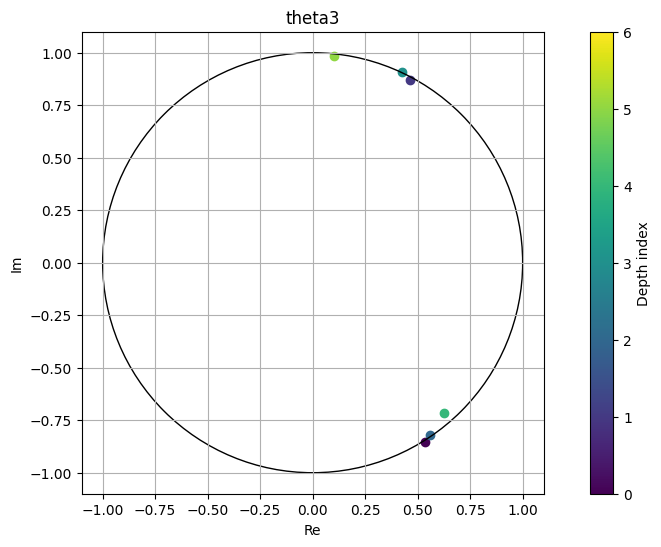

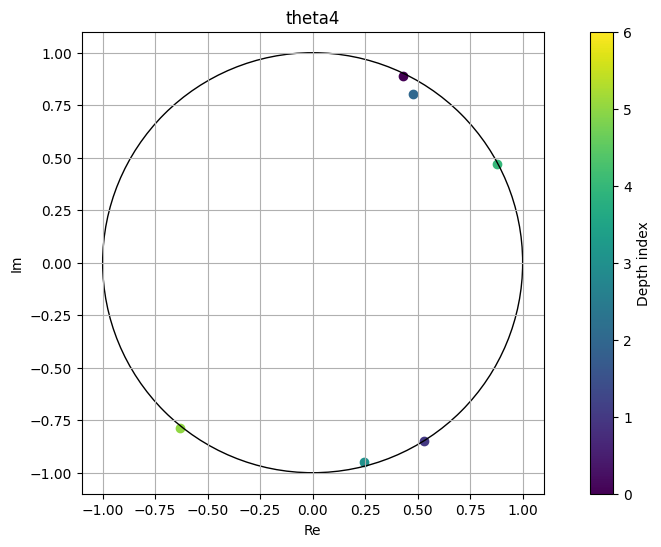

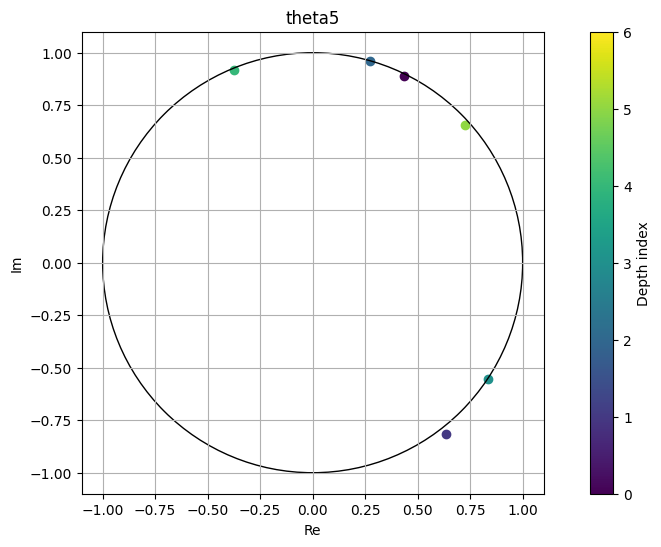

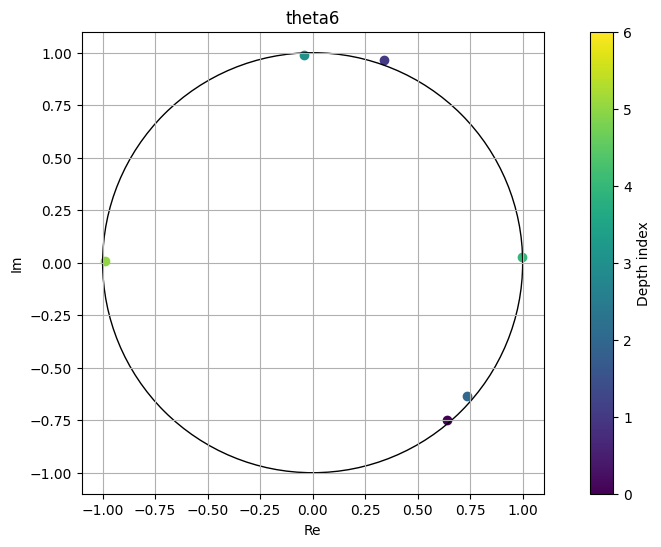

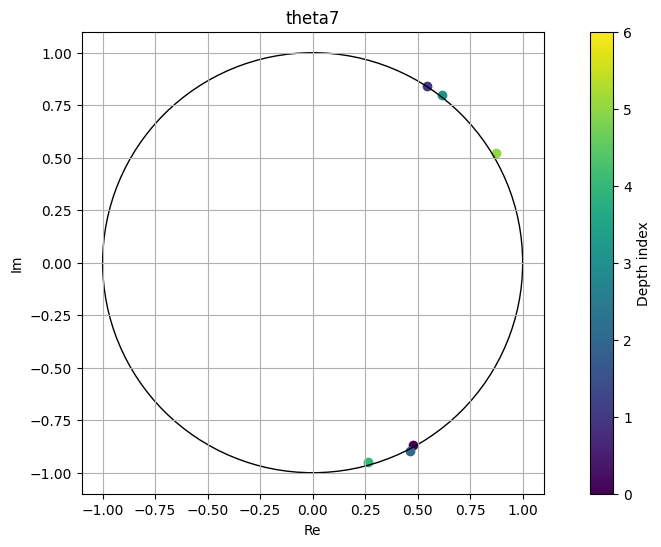

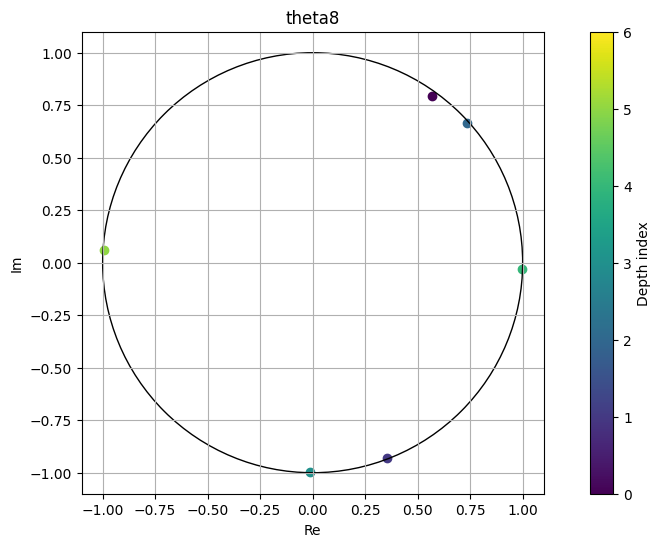

In [268]:
estimator_cz.plot_all_signals()